https://towardsdatascience.com/implementing-visualttransformer-in-pytorch-184f9f16f632

### Key points
    
    The input image is decomposed into 16x16 flatten patches (the image is not in scale). 
    Then they are embedded using a normal fully connected layer, 
    A special cls token is added in front of them and the positional encoding is summed. 
    The resulting tensor is passed first into a standard Transformer and then to a classification head.

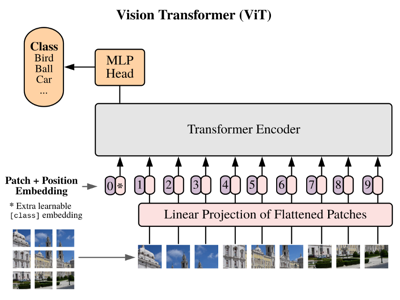

In [18]:
from io import BytesIO
import requests
from PIL import Image
r = requests.get('https://miro.medium.com/max/840/0*YRDqyaLnCJscrYWV')
Image.open(BytesIO(r.content)).resize((400,300))

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torchvision.transforms import Compose, Resize, ToTensor
from torchsummary import summary

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce


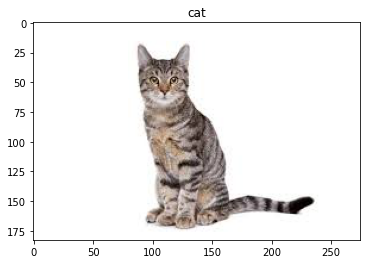

In [44]:
img = Image.open('./cat.jpg')
fig = plt.figure()
plt.imshow(img)
plt.title('cat')
plt.show()

In [47]:
# resize to 224x224

transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

In [57]:
## re-arrange to 16x16 patches
## https://einops.rocks/api/rearrange/

patch_size = 16 # 16 pixels
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
pathes.size()

torch.Size([1, 196, 768])

In [71]:
## wrapup projection as patch embedding Module - with linear projection

class patchEmbedding(nn.Module):
    
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        super().__init__() # init nn modeul
        self.projection = nn.Sequential(
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size))
    
    def forward(self, x: Tensor)-> Tensor:
        x = self.projection(x)
        return x
        
# test
patchEmbedding()(x).shape

torch.Size([1, 196, 768])

In [66]:
class patchEmbedding(nn.Module):
    
    def __init__(self, in_channels: int=3, patch_size: int = 16, emb_size: int=768):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b d (h) (w) -> b (h w) d'))        
    
    def forward(self, x):
        x = self.projection(x)
        return x
    
# test
patchEmbedding()(x)

tensor([[[-0.4159, -0.4581, -0.4628,  ..., -0.5490, -0.3926,  0.6004],
         [-0.4159, -0.4581, -0.4628,  ..., -0.5490, -0.3926,  0.6004],
         [-0.4159, -0.4581, -0.4628,  ..., -0.5490, -0.3926,  0.6004],
         ...,
         [-0.4159, -0.4581, -0.4628,  ..., -0.5490, -0.3926,  0.6004],
         [-0.4159, -0.4581, -0.4628,  ..., -0.5490, -0.3926,  0.6004],
         [-0.4159, -0.4581, -0.4628,  ..., -0.5490, -0.3926,  0.6004]]],
       grad_fn=<ViewBackward>)

In [73]:
## Add Class Tocken
class patchEmbedding(nn.Module):
    
    def __init__(self, in_channels: int=3, patch_size: int=16, emb_size: int=768):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b d (h) (w) -> b (h w) d'))
        
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        return x
    
# test
patchEmbedding()(x).shape

torch.Size([1, 197, 768])

In [82]:
## ADD positional embedding
class PatchEmbedding(nn.Module):
    
    def __init__(self, in_channels: int=3, patch_size: int=16, emb_size: int=768, img_size: int = 224):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b d (h) (w) -> b (h w) d'))
        
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        
        # add position embedding
        x += self.positions
        
        return x
    
# test
patchEmbedding()(x).shape


torch.Size([1, 197, 768])

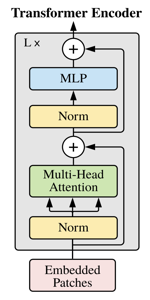

In [83]:
# add transormer encoder
r = requests.get('https://miro.medium.com/max/593/0*CEAbGqaYWUf-70n0')
Image.open(BytesIO(r.content)).resize((150,300))

In [85]:
## implement multihead attention

class MultiHeadAttention(nn.Module):
    
    def __init__(self, emb_size: int=768, num_heads: int=8, dropout: float = 0):        
        # init
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads        
        # q,k,v container
        self.qkv = nn.Linear(emb_size, emb_size*3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
    
    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        # split q, k, v
        qkv = rearrange(self.qkv(x), 'b c (w h qkv) -> (qkv) b w c h', h = self.num_heads, qkv = 3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sumup over last axis for queries and keys
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(troch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim = -1) / scaling
        att = self.att_drop(att)
        # sum over thrid axis 
        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

In [87]:
# residule block
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        return res+x

In [95]:
# add feedforward block

class FeedForwardBlock(nn.Module):
    def __init__(self, emb_size: int, expansion: int =4, drop_p: float = 0):
        super().__init__()
        self.Linear1 = nn.Linear(emb_size, expansion * emb_size)
        self.Linear2 = nn.Linear(expansion * emb_size, emb_size)
        self.GELU = nn.GELU()
        self.Dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        x = self.Linear1(x)
        x = self.GELU(x)
        x = self.Dropout(x)
        x = self.Linear2(x)
        return x

In [96]:
# buid transformer encoder as a whole

class TransformerEncoderBlock(nn.Module):
    
    def __init__(self, emb_size: int = 768, drop_p: float = 0, forward_expansion: int = 4, 
                 forward_drop_p: float = 0., **kwargs):
        
        super().__init__()
        
        self.res1 = ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size), 
            MultiHeadAttention(emb_size, **kwargs),
            nn.Dropout(drop_p)))
        
        self.res2 = ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
            nn.Dropout(drop_p)))
        
    def forward(self, x):
        x = self.res1(x)
        x = self.res2(x)
        return x
        
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [97]:
## stack together as transformer
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


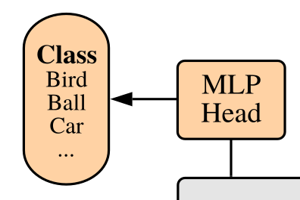

In [101]:
# add transormer encoder
r = requests.get('https://miro.medium.com/max/475/0*OWjU6c9qXmzrUTLq')
Image.open(BytesIO(r.content)).resize((300,200))

In [102]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [103]:
## wrap-up as ViT
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )


In [104]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6         [-1, 96, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

In [108]:
ViT()(x).shape

torch.Size([1, 1000])